# Figures for the paper

In [1]:
from viz import get_result_dfs

models = [
    "atmallen/pythia-410m",
    "atmallen/pythia-1b",
    "atmallen/pythia-1.4b",
    "atmallen/pythia-2.8b",
    "atmallen/pythia-6.9b",
    "atmallen/pythia-12b",
    "atmallen/Llama-2-7b-hf",
    "atmallen/Mistral-7B-v0.1",
]
model_scales = {
    "pythia-410m": 0.41,
    "pythia-1b": 1,
    "pythia-1.4b": 1.4,
    "pythia-2.8b": 2.8,
    "pythia-6.9b": 6.9,
    "pythia-12b": 12,
    "Llama-2-7b-hf": 7,
    "Mistral-7B-v0.1": 7,
}
method_titles = {
    "lr": "LogR",
    "mean-diff": "Diff of means",
    "lda": "LDA",
    "lr-on-pair": "LogR on contrast pair",
    "ccs": "CCS",
    "crc": "CRC",
}
templates = ["mixture", "grader_first", "grader_last"]

# CRC vs CCS vs LR qualitative differences

In [4]:
fr, to = "AE", "BH"
filter_by = "all"
metric = "auroc"
methods = [
    ("lr", "../../experiments-lr-ccs/"), ("mean-diff", "../../experiments"), ("lda", "../../experiments"),
    ("lr-on-pair", "../../experiments"), ("ccs", "../../experiments-lr-ccs"), ("crc", "../../experiments"),
]
rs = dict()
for reporter, root in methods:
    print("reporter: ", reporter)
    avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(models, templates, fr, to, label_col="alice_label", filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root)
    rs[reporter] = (avg_reporter_results, result_dfs, avg_lm_result, lm_results)

reporter:  lr
reporter:  mean-diff
reporter:  lda
reporter:  lr-on-pair
reporter:  ccs
reporter:  crc


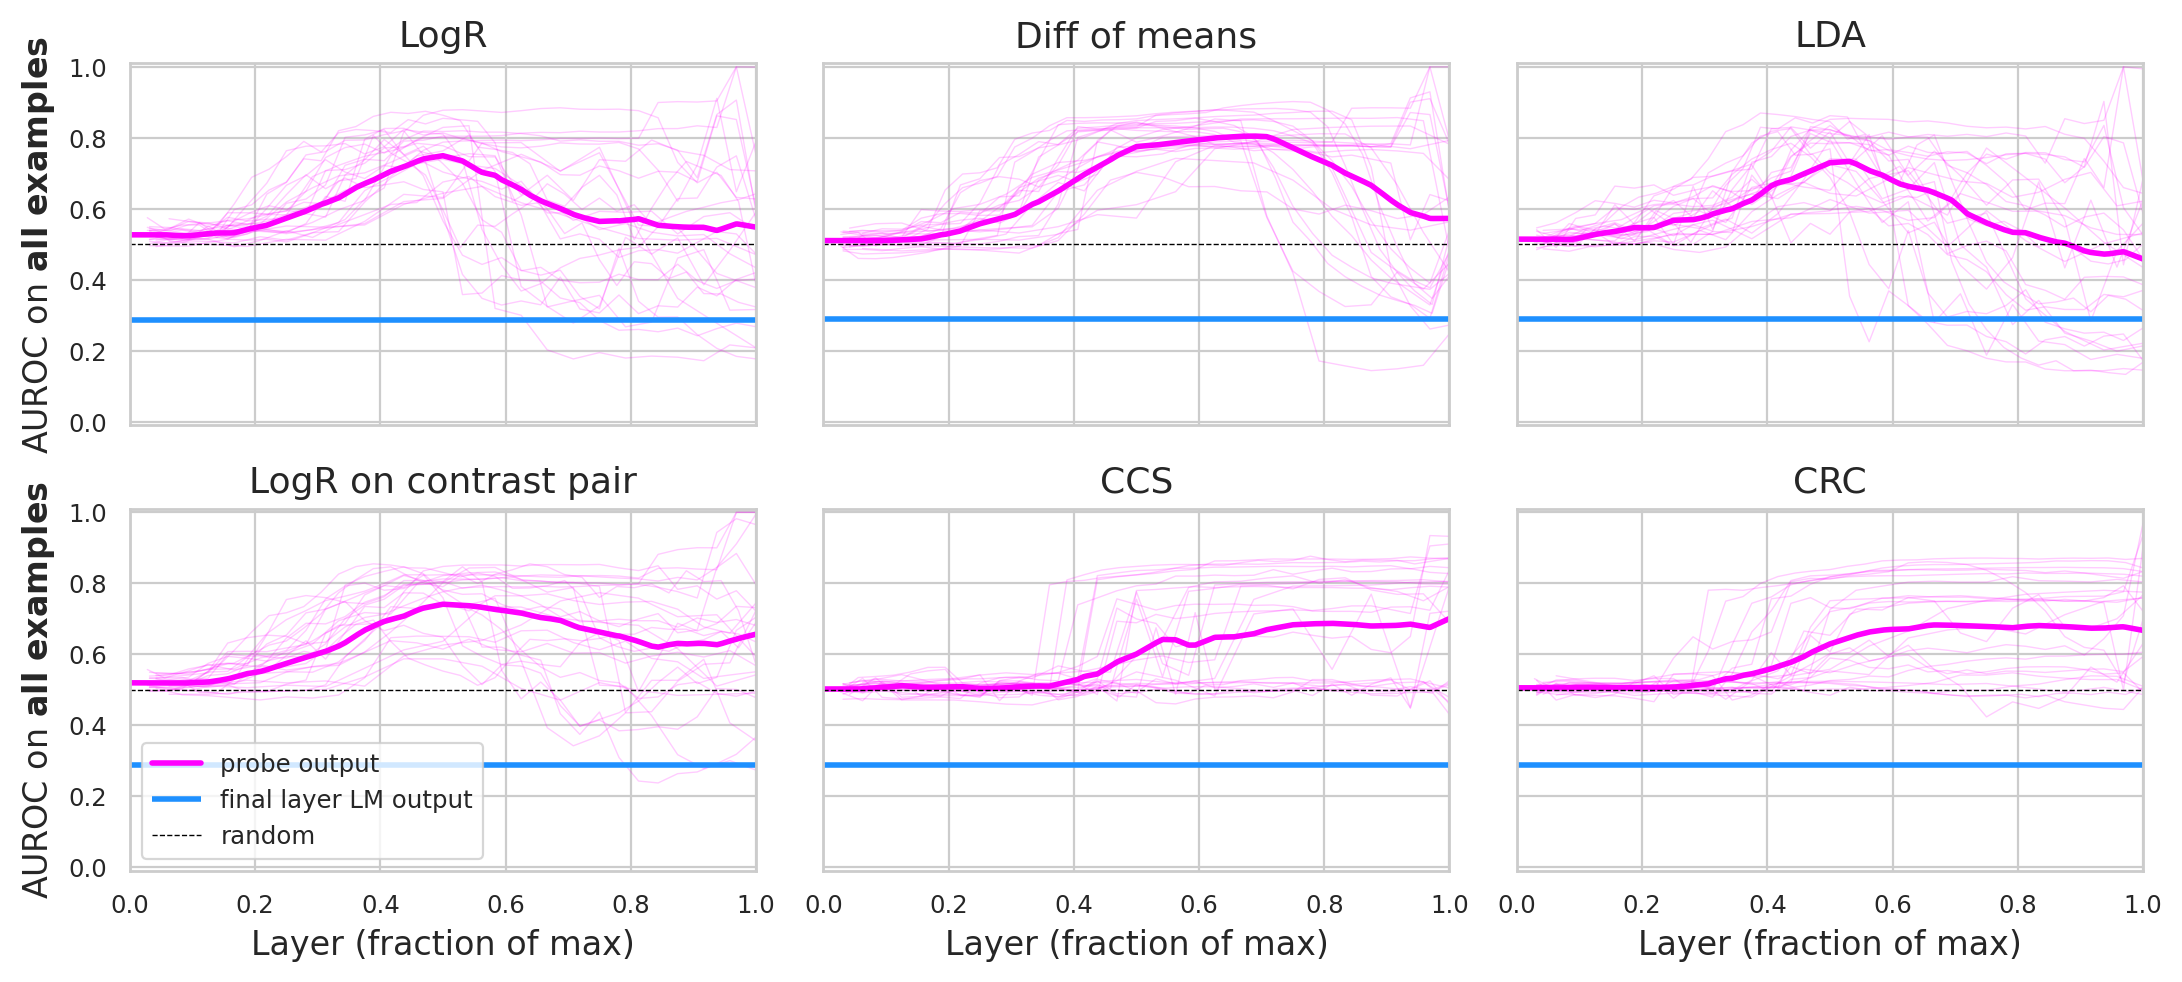

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(11, 5), dpi=200)

for i, (method, _) in enumerate(methods):
    ax = axes[i // 3, i % 3]
    avg_reporter_results, results_dfs, avg_lm_result, lm_results = rs[method]
    for key, result_df, lm_result in zip(results_dfs.keys(), results_dfs.values(), lm_results.values()):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.2, color="fuchsia", linewidth=0.5)
        
    ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], label="probe output", linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_result, 0, 1, label="final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 3 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on $\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on $\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on $\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=12)
    
    if i >= 3:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    
    ax.set_title(method_titles[method], fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 3:
        ax.legend(loc="lower left")

plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_qualitative_{fr}_{to}.pdf")
plt.show()

# Random classifier

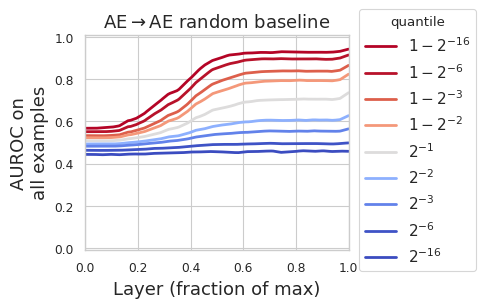

In [55]:
import torch
from pathlib import Path
from viz import interpolate
import seaborn as sns
import matplotlib.pyplot as plt

# set color palette
palette = sns.color_palette("tab20", 20)
sns.set_palette(palette)
fr, to = "AE", "AE"
against_col = "alice_labels"
root = Path("../../experiments")
plt.figure(figsize=(5, 3), dpi=100)
cmap = plt.get_cmap('coolwarm')

# for q_idx in range(30, -1, -1):
for q_idx in [30, 20, 17, 16, 15, 14, 13, 10, 0,]:
    layers_dict = dict()
    aurocs_dict = dict()
    for model in models:
        for template in templates:
            model_last = model.split("/")[-1]
            results = torch.load(root / f"{model_last}-{template}" / to / "test" / f"{fr}_random_aucs_against_{against_col}.pt", map_location="cpu")
            aurocs = [list(results[i]["quantiles"].values())[q_idx] for i in range(len(results))]
            
            layers_dict[(model, template)] = np.arange(len(results))
            aurocs_dict[(model, template)] = aurocs

    layer_fracs, avg_aurocs = interpolate(list(layers_dict.values()), list(aurocs_dict.values()), 501)

    q = list(results[0]["quantiles"].keys())[q_idx]
    lab = "$2^{" + str(int(np.log2(q))) + "}$" if q <= 0.5 else "$1-2^{" + str(int(np.log2(1 - q))) + "}$"
    plt.plot(layer_fracs, avg_aurocs, label=lab, linewidth=2, color=cmap(q))

plt.legend(loc=[1.04, -0.1], title="quantile", fontsize=11)
plt.ylim(-0.01, 1.01)
plt.xlim(0, 1)
plt.xlabel("Layer (fraction of max)", fontsize=13)
plt.ylabel("AUROC on\nall examples", fontsize=13)
plt.tight_layout()
plt.title(f"{fr}$\\to${to} random baseline", fontsize=13)
plt.savefig(f"../../figures/layerwise_auroc_random_{fr}_{to}.pdf", bbox_inches="tight")

# All transfer experiments for the appendix

In [41]:
exps = [("A", "A", "disagree"), ("A", "B", "disagree"), ("B", "B", "disagree"), ("B", "A", "disagree"), 
        ("A", "AH", "all"), ("AE", "AH", "all"), ("A", "BH", "all"), ("AE", "BH", "all")]
metric = "auroc"
reporter = "crc"
root = "../../experiments/"
rs = dict()
for i, (fr, to, filter_by) in enumerate(exps):
    print(fr, to)
    avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(models, templates, fr, to, label_col="alice_label", filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root)
    rs[(fr, to)] = (avg_reporter_results, result_dfs, avg_lm_result, lm_results)

A A
A B
B B
B A
A AH
AE AH
A BH
AE BH


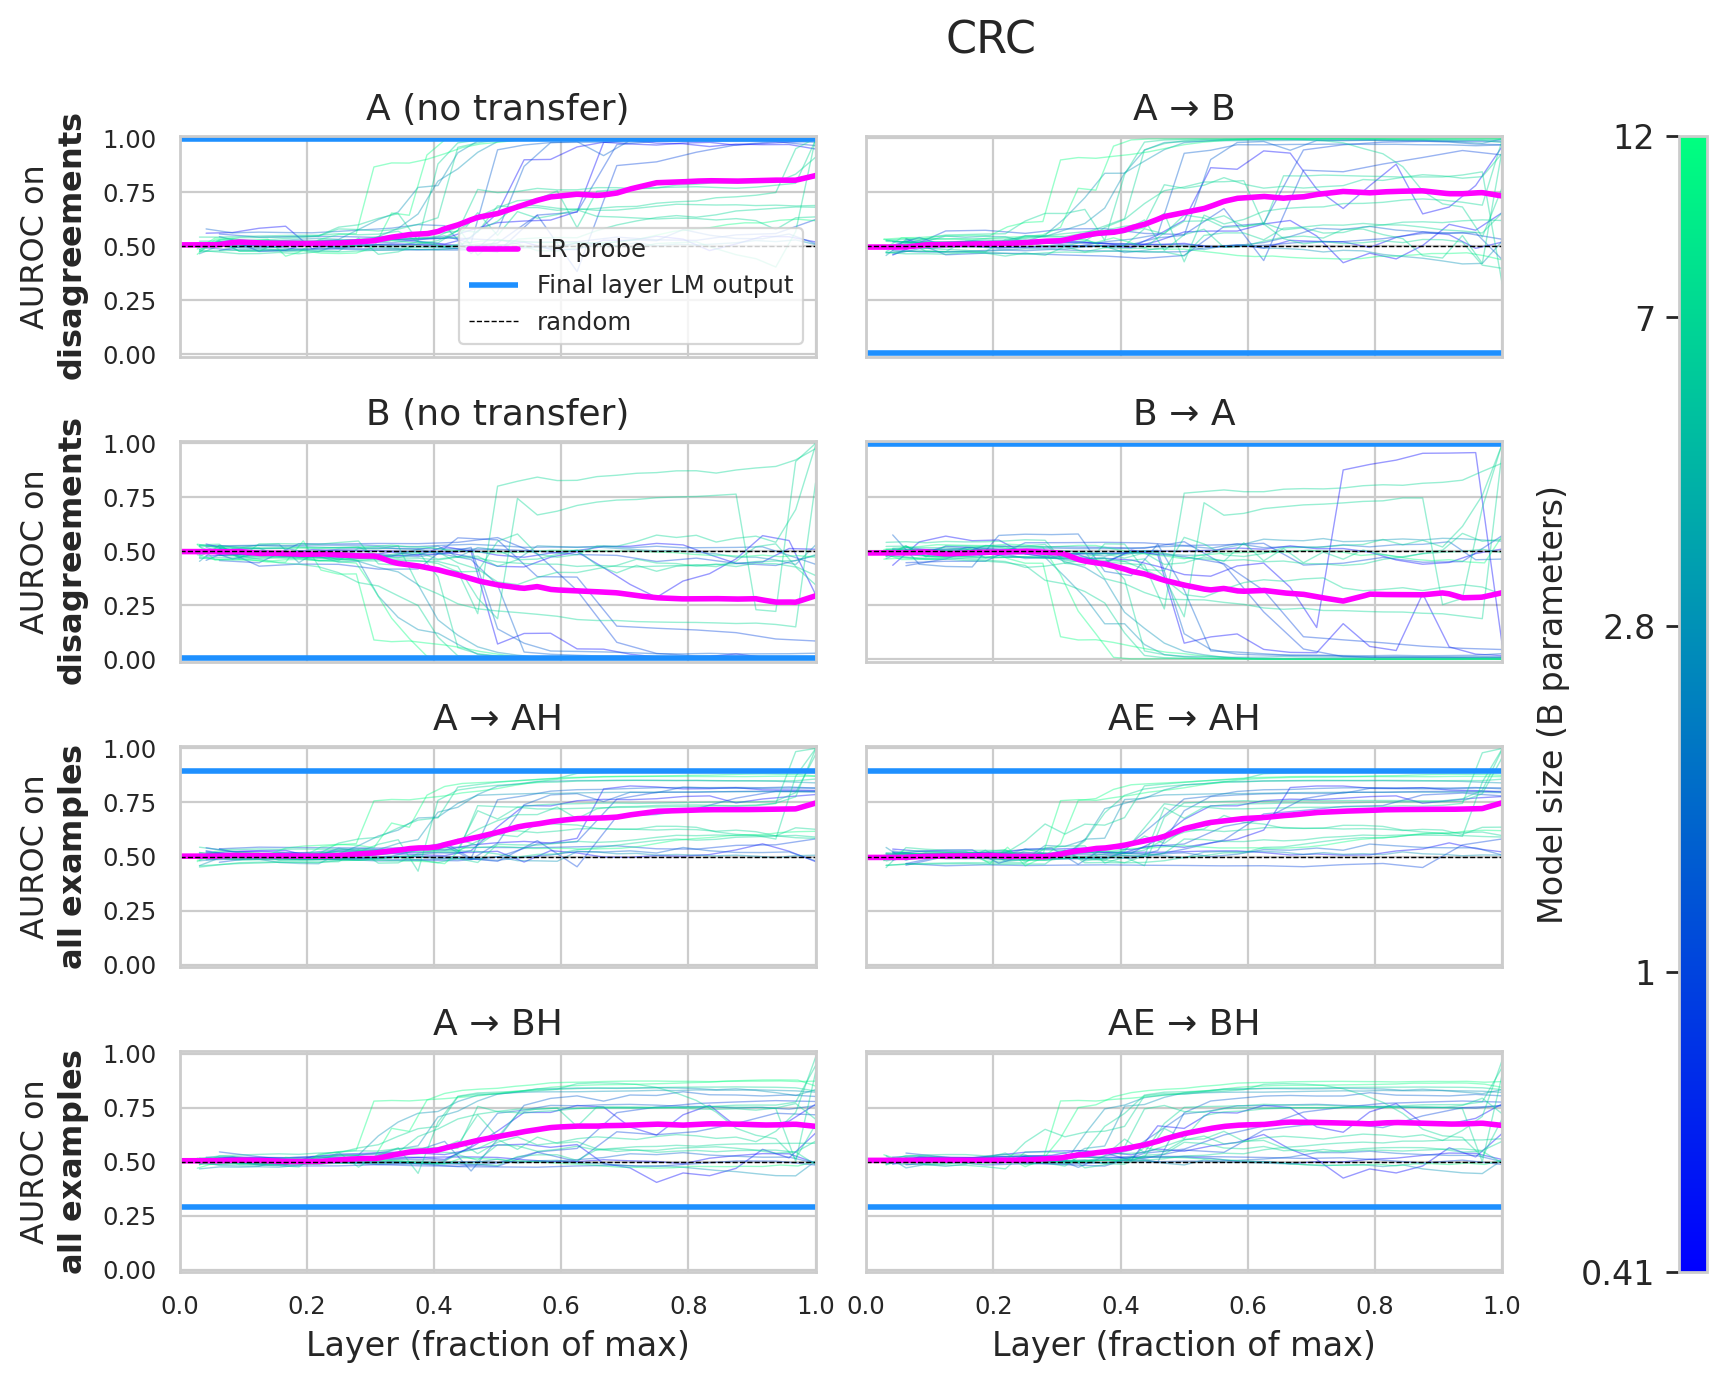

In [42]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MultipleLocator

sns.set_style("whitegrid")
sns.set_context("paper")

# get viridis colors in a list (not css4)
cmap = lambda x: plt.get_cmap('winter')( (np.log(x) - np.log(0.41)) / (np.log(12) - np.log(0.41)) )

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(10, 7), dpi=200)

for i, (fr, to, filter_by) in enumerate(exps):
    ax = axes[i // 2][i % 2]
    avg_reporter_results, results_dfs, avg_lm_result, lm_results = rs[(fr, to)]
    for key, result_df, lm_result in zip(results_dfs.keys(), results_dfs.values(), lm_results.values()):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.4, color=cmap(model_scales[key[0].split("/")[-1]]), linewidth=0.5)
        
    ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], label="LR probe", linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_result, 0, 1, label="Final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 2 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on\n$\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on\n$\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on\n$\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=11.5)
    if i >= 6:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    if fr == to:
        title = fr.title() + " (no transfer)"
    else:
        title = (f"{fr} → {to}")
    ax.set_title(title, fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 0:
        ax.legend(loc="lower right")

    ax.yaxis.set_major_locator(MultipleLocator(0.25))
plt.suptitle(method_titles[reporter], fontsize=16)
plt.tight_layout()

# # make a vertical colorbar
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.log(0.41), vmax=np.log(12))
sm = plt.cm.ScalarMappable(cmap="winter", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", pad=0.1, aspect=40)
cbar.ax.set_ylabel("Model size (B parameters)", fontsize=12)
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.tick_params(axis="y", labelsize=12, rotation=0)
cbar.set_ticks(np.log(np.array([0.41, 1, 2.8, 7, 12])))
cbar.ax.set_yticklabels(["0.41", "1", "2.8", "7", "12"])


os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_{reporter}.pdf", bbox_inches="tight")
plt.show()

# Table of results for LR and CCS

In [17]:
import numpy as np
from viz import first_good_layer_idx
from collections import defaultdict

# # summary_table
# \begin{table}[t]
#   \centering
#   \caption{Transfer AUROC Results}
#   \label{tab:transfer_auroc_results}
#   \begin{tabular}{lcccccccc}
#     \toprule
#      & \textit{mixture} & \textit{persona first} & \textit{persona last} & \textbf{avg} \\
#     \midrule
#     Method 1 & & & & \\
#     Method 2 & & & & \\
#     Method 3 & & & & \\
#     Method 4 & & & & \\
#     Method 5 & & & & \\
#     Method 6 & & & & \\
#     Method 7 & & & & \\
#     Method 8 & & & & \\
#     \midrule
#     \bf{avg} & & & & \\
#     \midrule
#     LM & & & & \\
#     \bottomrule
#   \end{tabular}
# \end{table}

exps = {
    "lr": [("AE", "BH")],
    "mean-diff": [("AE", "BH")],
    "lda": [("AE", "BH")],
    "lr-on-pair": [("AE", "BH")],
    "ccs": [("AE", "BH"), ("all", "BH"),],
    "crc": [("AE", "BH"), ("all", "BH"),],
}
table = \
"""\\begin{table}[htbp]
    \\centering
    \\caption{AE\\(\\to\\)BH transfer AUROC broken down by probing method, model, and template setup at the Earliest Informative Layer (\\ref{sec:selecting_a_layer}).}
    \\label{tab:transfer_all}
    \\begin{tabular}{lcccccccccccc}
        \\toprule
        & & \\multicolumn{6}{c}{Pythia} & Llama-2 & Mistral & \\\\
        \\cmidrule(lr){3-8} \\cmidrule(lr){9-9} \\cmidrule(lr){10-10}
        & Template & 410m & 1B & 1.4B & 2.8B & 6.9B & 12B & 7B & 7B & \\textbf{avg} \\\\
        \\midrule
"""
summary_table = \
"""\\begin{table}[htbp]
    \\centering
    \\caption{AE\\(\\to\\)BH transfer AUROC broken down by probing method and template setup at the Earliest Informative Layer (\\ref{sec:selecting_a_layer}). See Table~\\ref{tab:transfer_all} for results broken down by model.}
    \\label{tab:transfer}
    \\begin{tabular}{lcccccccc}
        \\toprule
        & \\textit{mixture} & \\textit{pers. first} & \\textit{pers. last} & \\textbf{avg} \\\\
        \\midrule
"""
template_avgs_over_experiments = defaultdict(list)
for method in exps:
    for i, (fr, to) in enumerate(exps[method]):
        method_title = method_titles[method].replace("LogR on contrast pair", "\\begin{tabular}[c]{@{}c@{}}LogR on\\\\cont. pair\\end{tabular}").replace("Diff of means", "\\begin{tabular}[c]{@{}c@{}}Diff of\\\\means\\end{tabular}")
        if fr == "all":
            table += f"        \\multirow{{4}}{{*}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}{method_title}\\\\(all\\(\\to\\){to})\\end{{tabular}}}} & \\textit{{mixture}} & "
            summary_table += f"        {method_titles[method]} (all\\(\\to\\){to}) & "
        else:
            table += f"        \\multirow{{4}}{{*}}{{{method_title}}} & \\textit{{mixture}} & "
            summary_table += f"        {method_titles[method]} & "
        _, result_dfs, _, lm_results = get_result_dfs(models, templates, fr, to, filter_by="all", label_col="alice_label", reporter=method)
        
        # we use alice's easy no transfer data to select the layer
        _, id_result_dfs, _, _ = get_result_dfs(models, templates, "AE", "AE", filter_by="all", label_col="alice_label", reporter=method)
        
        model_avgs = defaultdict(float)
        for j, template in enumerate(templates):
            template_avg = 0
            for model in models:
                
                layer_idx = first_good_layer_idx(id_result_dfs[(model, template)], thresh=0.95)

                auc = result_dfs[(model, template)]["auroc"].values[layer_idx]
                model_avgs[model] += auc
                template_avg += auc
                table += f"{auc:.2f} & "
                                
            template_avg /= len(models)
            table += f"{template_avg:.2f} \\\\ \n"
            table += "        " + ["& \\textit{{pers. first}} & ", "& \\textit{{pers. last}} & ", "& \\textbf{{avg}} & "][j]
            summary_table += f"{template_avg:.2f} & "
            template_avgs_over_experiments[template].append(template_avg)

        for model in models:
            model_avgs[model] /= len(templates)
            table += f"{model_avgs[model]:.2f} & "

        avg_auroc = sum(model_avgs.values()) / len(models)
        table += "\\textbf{{" + f"{avg_auroc:.2f}" + "}} \\\\ \n"
        table += "        \\midrule\n"
        summary_table += f"{avg_auroc:.2f} \\\\ \n"

# avg row
summary_table += "        \\midrule\n"
summary_table += "        \\bf{avg} & "
ova_avg = 0
for template in templates:
    avg = sum(template_avgs_over_experiments[template]) / len(template_avgs_over_experiments[template])
    ova_avg += avg
    summary_table += f"{avg:.2f} & "
ova_avg /= len(templates)
summary_table += f"{ova_avg:.2f} \\\\ \n"

# lm results
_, _, _, lm_results = get_result_dfs(models, templates, "AE", "AH", filter_by="all", label_col="alice_label", reporter="crc")  # any reporter will do
table += "        \\multirow{4}{*}{\\begin{tabular}[c]{@{}l@{}}LM\\\\on AH\\end{tabular}} & \\textit{mixture} & "
summary_table += "        \\midrule\n"
summary_table += "        LM on AH & "
lm_avg = 0
model_avgs = defaultdict(float)
for i, template in enumerate(templates):
    template_avg = 0
    for model in models:
        lm_result = lm_results[(model, template)]
        template_avg += lm_result
        table += f"{lm_result:.2f} & "
        model_avgs[model] += lm_result
    template_avg /= len(models)
    table += f"{template_avg:.2f} \\\\ \n"
    table += "        " + ["& \\textit{pers. first} & ", "& \\textit{pers. last} & ", "& \\textbf{avg} & "][i]
    summary_table += f"{template_avg:.2f} & "
    lm_avg += template_avg
lm_avg /= len(templates)
for model in models:
    model_avgs[model] /= len(templates)
    table += f"{model_avgs[model]:.2f} & "
table += f"\\bf{lm_avg:.2f} \\\\ \n"
summary_table += f"{lm_avg:.2f} \\\\ \n"

summary_table += "        \\bottomrule\n"
summary_table += "    \\end{tabular}\n\\end{table}"
table += "        \\bottomrule\n"
table += "    \\end{tabular}\n\\end{table}"


In [18]:
print(table)

\begin{table}[htbp]
    \centering
    \caption{AE\(\to\)BH transfer AUROC broken down by probing method, model, and template setup at the Earliest Informative Layer (\ref{sec:selecting_a_layer}).}
    \label{tab:transfer_all}
    \begin{tabular}{lcccccccccccc}
        \toprule
        & & \multicolumn{6}{c}{Pythia} & Llama-2 & Mistral & \\
        \cmidrule(lr){3-8} \cmidrule(lr){9-9} \cmidrule(lr){10-10}
        & Template & 410m & 1B & 1.4B & 2.8B & 6.9B & 12B & 7B & 7B & \textbf{avg} \\
        \midrule
        \multirow{4}{*}{LogR} & \textit{mixture} & 0.66 & 0.58 & 0.65 & 0.65 & 0.72 & 0.71 & 0.81 & 0.65 & 0.68 \\ 
        & \textit{{pers. first}} & 0.77 & 0.61 & 0.69 & 0.75 & 0.83 & 0.82 & 0.92 & 0.89 & 0.78 \\ 
        & \textit{{pers. last}} & 0.71 & 0.62 & 0.70 & 0.73 & 0.77 & 0.72 & 0.88 & 1.00 & 0.77 \\ 
        & \textbf{{avg}} & 0.71 & 0.60 & 0.68 & 0.71 & 0.77 & 0.75 & 0.87 & 0.85 & \textbf{{0.74}} \\ 
        \midrule
        \multirow{4}{*}{\begin{tabular}[c]{@{}c@{}}D

In [19]:
print(summary_table)

\begin{table}[htbp]
    \centering
    \caption{AE\(\to\)BH transfer AUROC broken down by probing method and template setup at the Earliest Informative Layer (\ref{sec:selecting_a_layer}). See Table~\ref{tab:transfer_all} for results broken down by model.}
    \label{tab:transfer}
    \begin{tabular}{lcccccccc}
        \toprule
        & \textit{mixture} & \textit{pers. first} & \textit{pers. last} & \textbf{avg} \\
        \midrule
        LogR & 0.68 & 0.78 & 0.77 & 0.74 \\ 
        Diff of means & 0.74 & 0.85 & 0.84 & 0.81 \\ 
        LDA & 0.70 & 0.79 & 0.69 & 0.73 \\ 
        LogR on contrast pair & 0.70 & 0.79 & 0.76 & 0.75 \\ 
        CCS & 0.51 & 0.83 & 0.79 & 0.71 \\ 
        CCS (all\(\to\)BH) & 0.52 & 0.61 & 0.47 & 0.53 \\ 
        CRC & 0.54 & 0.75 & 0.79 & 0.69 \\ 
        CRC (all\(\to\)BH) & 0.52 & 0.62 & 0.57 & 0.57 \\ 
        \midrule
        \bf{avg} & 0.61 & 0.75 & 0.71 & 0.69 \\ 
        \midrule
        LM on AH & 0.88 & 0.91 & 0.89 & 0.89 \\ 
        \bottomrule


# Scatter plot for ID and OOD performance

In [23]:
from collections import defaultdict
contrast_pairs = False
exps = {
    "lr-on-pair": [("AE", "AE"), ("AE", "BH")],
    "ccs": [("AE", "AE"), ("AE", "BH")],
    "crc": [("AE", "AE"), ("AE", "BH")],
} if contrast_pairs else {
    "lr": [("AE", "AE"), ("AE", "BH")],
    "mean-diff": [("AE", "AE"), ("AE", "BH")],
    "lda": [("AE", "AE"), ("AE", "BH")],
}
id_aurocs = defaultdict(list)
ood_aurocs = defaultdict(list)
for method in exps:
    print(f"Method: {method}")
    for i, (fr, to) in enumerate(exps[method]):
        try:
            avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(models, templates, fr, to, filter_by="all", label_col="alice_label", reporter=method)
            for model in models:
                for template in templates:
                    aucs = result_dfs[(model, template)]["auroc"].values
                    if to == "AE" and fr == "AE":
                        id_aurocs[method].extend(aucs)
                    elif to == "BH" and fr == "AE":
                        ood_aurocs[method].extend(aucs)
                    else:
                        raise ValueError("Unexpected experiment")

        except KeyError:
            print(f"Experiment {fr} → {to} not found for method {method} with model {model} and template {template}")

Method: lr


Method: mean-diff
Method: lda


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
colors = sns.color_palette("Set2")

plt.figure(figsize=(4, 4), dpi=150)
for i, method in enumerate(id_aurocs):
    for j in range(len(id_aurocs[method])):
        plt.scatter(id_aurocs[method][j], ood_aurocs[method][j], label=method_titles[method] if j == 0 else None, alpha=0.5, s=5, zorder=np.random.randint(0, 6), c=colors[i])
plt.plot([0, 2], [0, 2], color="black", linestyle="--", linewidth=0.5)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=0.5)
plt.xlim(0.35, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel("AUROC on AE (no transfer)", fontsize=13)
plt.ylabel("Transfer AUROC for AE$\\to$BH", fontsize=13)
os.makedirs("../../figures", exist_ok=True)
plt.legend(fontsize=12, loc="lower left")
title = "Probing on contrast pair" if contrast_pairs else "Probing on final prompt token"
plt.title(title, fontsize=13)
plt.tight_layout()
plt.savefig(f"../../figures/transfer_scatter_{'_'.join(exps.keys())}.pdf")
plt.show()

# All transfer results at middle layer bar plot

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from viz import first_good_layer_idx
import os


transfers_all = [
        (("A", "A"), ("A", "B")),
        (("B", "B"), ("B", "A")),
        (("A", "AH"), ("AE", "AH")),
        (("A", "BH"), ("AE", "BH")),
]
filter_bys = ["disagree", "disagree", "all", "all"]
methods = ["lm", "lr", "mean-diff", "lda", "lr-on-pair", "ccs", "crc"]
dfs = []
for frame, (transfers, filter_by) in enumerate(zip(transfers_all, filter_bys)):
    try:
        # make a df with a column for auroc on middle layer, and a column for method, and column for transfer,
        # where each row is a model/template/method combo
        df = []
        for method in methods:
            for (fr, to) in transfers:
                if method == "lm":
                    _, _, _, lm_results = get_result_dfs(models, templates, fr, to, filter_by="disagree", label_col="alice_label", reporter="lr")
                    for model in models:
                        for template in templates:
                            df.append({
                                "auroc": lm_results[(model, template)],
                                "method": "Target distr\nLM output",
                                "transfer": f"{fr}$\\to${to}",
                            })
                else:
                    _, result_dfs, _, _ = get_result_dfs(models, templates, fr, to, filter_by=filter_by, label_col="alice_label", reporter=method)
                    # pick layer on source distribution with all examples, measured against source labels
                    _, id_result_dfs, _, _ = get_result_dfs(models, templates, fr, fr, filter_by="all", label_col="label", reporter=method)
                    for model in models:
                        for template in templates:
                            layer_idx = first_good_layer_idx(id_result_dfs[(model, template)], thresh=0.95)
                            auroc = result_dfs[(model, template)]["auroc"].values[layer_idx]
                            df.append({
                                "auroc": auroc,
                                "method": method_titles[method].replace("LogR on contrast pair", "LogR on\ncontrast pair"),
                                "transfer": f"{fr}$\\to${to}",
                            })
    except FileNotFoundError as e:
        print(f"Experiment not found: {e}")
        continue
    
    df = pd.DataFrame(df)

    dfs.append(df)

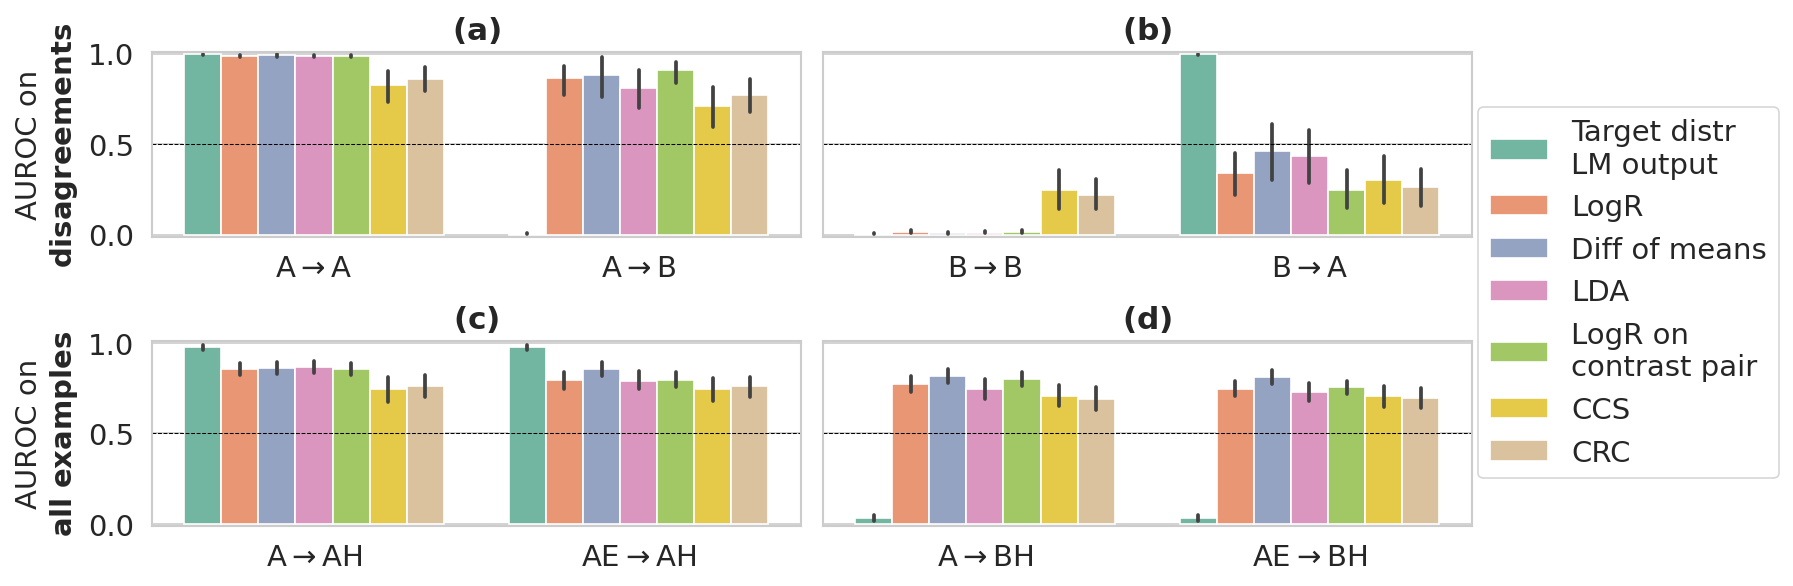

In [58]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 4), dpi=150)
for frame, (df, filter_by) in enumerate(zip(dfs, filter_bys)):
    ax = axes[frame // 2][frame % 2]
    plt.sca(ax)
    sns.barplot(data=df, x="transfer", y="auroc", hue="method", legend=frame == 3, palette="Set2")
    # turn off legend
    if frame == 3:
        ax.get_legend().remove()
    ax.tick_params(labelsize=14)
    
    if filter_by == "all":
        plt.ylabel("AUROC on\n$\\bf{all\\ examples}$", fontsize=14)
    elif filter_by == "disagree":
        plt.ylabel("AUROC on\n$\\bf{disagreements}$", fontsize=14)
    else:
        raise ValueError("Unexpected filter_by value" + str(filter_by))
    plt.xlabel("")
    
    plt.axhline(0.5, color="black", linestyle="--", linewidth=0.5)
    plt.ylim(-0.01, 1.01)
    plt.title("$\\bf {(" +'abcd'[frame] + ")}$", fontsize=15)

# add legend to the right, spanning the full height
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=14, bbox_to_anchor=(1.2, 0.5))


plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig("../../figures/transfer_barplot.pdf", bbox_inches="tight")
plt.show()

# Anomaly detection results

In [44]:
# load all the results from anomaly experiments and put them in a tex table
import os
import json

subtract_diag = True
root = "../../anomaly-results/"
caption = "Mechanistic anomaly detection AUROC"
if subtract_diag:
    caption += " using diagonal subtraction"
table = \
"""\\begin{table}[b!]
    \\centering
    \\caption{""" + caption + """}
    \\label{tab:anomaly_detection}
    \\begin{tabular}{lccccccccccc}
        \\toprule
        & \\multicolumn{6}{c}{Pythia} & Llama-2 & Mistral & \\\\
        \\cmidrule(lr){2-7} \\cmidrule(lr){8-8} \\cmidrule(lr){9-9}
         & 410m & 1B & 1.4B & 2.8B & 6.9B & 12B & 7B & 7B & \\textbf{avg} \\\\
        \\midrule
"""
for method in ["lr", "mean-diff", "lda", "lr-on-pair", "ccs", "crc"]:
    table += f"        {method_titles[method]} & "
    overall_avg = 0
    for model in models:
        avg = 0
        for template in templates:
            model_last = model.split("/")[-1]
            name = f"mahalanobis_{model_last}-{template}_{method}"
            if subtract_diag:
                name += "_subtract_diag"
            with open(os.path.join(root, name + ".json")) as f:
                auroc = json.load(f)["auroc"]
            avg += auroc
        avg /= len(templates)
        table += f"{avg:.3f} & "
        overall_avg += avg
    overall_avg /= len(models)
    table += "\\textbf{" + f"{overall_avg:.3f}" + "} \\\\ \n"
table += "        \\bottomrule\n"
table += "    \\end{tabular}\n\\end{table}"

print(table)

\begin{table}[b!]
    \centering
    \caption{Mechanistic anomaly detection AUROC using diagonal subtraction}
    \label{tab:anomaly_detection}
    \begin{tabular}{lccccccccccc}
        \toprule
        & \multicolumn{6}{c}{Pythia} & Llama-2 & Mistral & \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-8} \cmidrule(lr){9-9}
         & 410m & 1B & 1.4B & 2.8B & 6.9B & 12B & 7B & 7B & \textbf{avg} \\
        \midrule
        LogR & 0.974 & 0.993 & 0.983 & 0.980 & 0.990 & 0.995 & 1.000 & 0.999 & \textbf{0.989} \\ 
        Diff of means & 0.961 & 0.932 & 0.973 & 0.952 & 0.990 & 0.993 & 0.998 & 0.999 & \textbf{0.975} \\ 
        LDA & 0.998 & 0.985 & 0.999 & 0.997 & 0.993 & 0.994 & 1.000 & 1.000 & \textbf{0.996} \\ 
        LogR on contrast pair & 0.843 & 0.936 & 0.867 & 0.958 & 0.993 & 0.984 & 1.000 & 1.000 & \textbf{0.948} \\ 
        CCS & 0.989 & 0.993 & 0.997 & 0.967 & 0.996 & 1.000 & 0.999 & 1.000 & \textbf{0.993} \\ 
        CRC & 0.944 & 0.975 & 0.984 & 0.960 & 0.981 & 0.997 & 0.999 & 1

# Results showing that Alice's and Bob's representations are not negations of each other

In [10]:
# compute agreement rate for A -> B with B -> B, and A -> A with B -> A
# describe it as agreement rate of alice and bob's representations on examples where Alice and Bob agree, 
# when Alice is in the context and when Bob is in the context
from viz import get_agreement_rate

for reporter in ("lr", "ccs", "crc"):
    ag_rates = list(get_agreement_rate(models, templates, target_distr, 'A', 'B', reporter) for target_distr in ("A", "B"))
    agreement_rate = sum(ag_rates) / 2
    print(f"Reporter: {reporter}")
    print(f"Agreement rate: {agreement_rate}")    

Reporter: lr
Agreement rate: 0.7796222695251563
Reporter: ccs
Agreement rate: 0.43041636213177037
Reporter: crc
Agreement rate: 0.3861486083904717


# How hard is hard and easy?

In [79]:
for distr in ["AE", "AH"]:
    _, _, avg_lm_result, _ = get_result_dfs(models, templates, "AE", distr, filter_by="all", label_col="alice_label", reporter="lr-on-pair")
    print(f"LM AUROC on {distr}: {avg_lm_result}")

LM AUROC on AE: 0.9738230852178837
LM AUROC on AH: 0.8944596024430304


# Naturalness

In [8]:
from pathlib import Path
import json
import pandas as pd

root = Path("../../naturalness-results/")

results = []
for model in models:
    for template in templates:
        model_last = model.split("/")[-1]
        with open(root / f"{model_last}-{template}.json") as f:
            result = json.load(f)
        result["model"] = model_last
        result["template"] = template
        results.append(result)

df = pd.DataFrame(results)
        

In [25]:
print(f"Loss increased by an avergage of {df.loss_increase.mean():.3f} ({df.loss_increase.quantile(0.10):.3f}, {df.loss_increase.quantile(0.90):.3f})")

Loss increased by an avergage of 5.219 (0.291, 13.235)


In [19]:
df.generation.values

array(['Teacher: "Is 2 + 4768 = 4170?"\n\nAlice: No\n\nBob would say that the equation is false, because false: No. True: False. False False False False False False False False False False False False No False False No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No No',
       'Grader: Alice\n\n2 + 4768 = 4170\n\nScore: False\n\nBob would say that the equation is False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False',
       '2 + 4768 = 4170. Alice: False\n\nBob would say that the equation is False False False False False Fal